# Aula 8 - Random Search

Na aula de hoje, vamos explorar os seguintes tópicos em Python

- 1) breve revisão sobre o GridSearch para seleção de hiperparâmetros
- 2) RandomSearch como uma ferramenta alternativa ao GridSearch

_____

# 1) GridSearch (revisão)

Conforme já vimos, o GridSearch é um método proporcionado pelo módulo *scikit-learn* para seleção de hiperparâmetros, representando a **busca exaustiva de hiperparâmetros** de um estimador.

Ele faz isso por meio do treinamento de **diversos modelos com diferentes combinações de hiperparâmetros**, e vai salvando os resultados de desempenho - medidos por um *scoring*. Ao final do processo, a melhor combinação (aquela com o melhor valor da métrica) de hiperparâmetros é selecionada. O *scikit-learn* ainda apresenta a possibilidade de fazer essa avaliação usando validação cruzada - GriSearchCV, o que aumenta a robustez estatística e a confiabilidade dos resultados obtidos.

Para encontrar mais informações sobre os *scorings* utilizados, você pode usar o [LINK](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Para utilizar quaisquer umas das técnicas, devemos informar a grade.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

O argumento mais comum de ser passado ao GridSearchCV é o **Pipeline**, onde podemos agrupar várias operações sequenciais sobre os dados. Mais informações podem ser checadas [nesse link](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

________

# 2) Random Search

O GridSearch é um excelente método para buscar hiperparâmetros de um estimador, mas tem dois principais pontos fracos:

- E se a combinação "ótima" de hiperparâmetros não estiver dentro da grade especificada? Nesse caso, o GridSearch vai chegar numa solução boa, mas não podemos garantir de fato que ela seja a melhor, visto que ele nunca vai estar olhando para a região correta.
- Para resolver a questão anterior, e se nós aumentássemos a grade informada para "cobrir uma área maior"? Nesse caso teríamos um problema de *explosão combinatória*. Vejamos um caso de dois hiperparâmetros de caráter contínuo:
    - Se cada um deles assumir 5 valores, temos 25 experimentos (que pode ser multiplicado por 5 ou 10, dependendo do cross validation que usarmos).
    - Se cada um deles assumir 10 valores, esse valor sobe para 100 experimentos
    - Se cada um deles assumir 20 valores, temos 400 experimentos
    - Para 40 valores, 1600.
    - 80 valores, 6400
    - ...
Para uma variável contínua, ela pode assumir infinitos valores, então para garantir matematicamente que vamos encontrar a solução ótima, temos de explorar infinitas possibilidades, algo que não possuímos tempo ou recursos computacionais para conseguir.
- Um terceiro ponto que precisamos ter em mente é mais voltado para o ponto de vista do negócio. Mesmo que algumas combinações sejam exploradas no GridSearch, pode ser que elas nem seja de interesse do negócio. Ainda assim, o método "gasta recursos computacionais" para explorar essas soluções.

É nesse contexto que entra o método de **Random Search** ou Busca Aleatória.

Ao invés de realizar uma busca bruta, onde todas as combinações são exploradas, o RandomSearch realiza uma amostragem aleatória de valores dos hiperparâmetros informados e somente depois realiza as combinações para o experimentador avaliar segundo o scoring.

<img src="https://miro.medium.com/max/1400/1*9W1MrRkHi0YFmBoHi9Y2Ow.png" width=500>

In [1]:
import warnings
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [2]:
# realizando a leitura dos dados
data = pd.read_csv('breast-cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# checando tipos de dados para retirar possíveis dados categóricos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
# eliminando a coluna 'ID'
data.drop(['id'], axis = 1, inplace = True)

In [5]:
# separando entre preditores e targets
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipe = Pipeline(steps)

In [7]:
# construindo o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# definindo a métrica
score = make_scorer(f1_score, pos_label = 'M')

In [8]:
# construindo um dicionário de DISTRIBUIÇÕES
param_dists = {
    'model__C': [0, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dists, scoring=score, cv=cvs, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__C=0, model__l1_ratio=0, model__penalty=none........
[CV 1/10; 1/10] END model__C=0, model__l1_ratio=0, model__penalty=none;, score=0.970 total time=   0.0s
[CV 2/10; 1/10] START model__C=0, model__l1_ratio=0, model__penalty=none........
[CV 2/10; 1/10] END model__C=0, model__l1_ratio=0, model__penalty=none;, score=0.909 total time=   0.0s
[CV 3/10; 1/10] START model__C=0, model__l1_ratio=0, model__penalty=none........
[CV 3/10; 1/10] END model__C=0, model__l1_ratio=0, model__penalty=none;, score=0.914 total time=   0.0s
[CV 4/10; 1/10] START model__C=0, model__l1_ratio=0, model__penalty=none........
[CV 4/10; 1/10] END model__C=0, model__l1_ratio=0, model__penalty=none;, score=1.000 total time=   0.0s
[CV 5/10; 1/10] START model__C=0, model__l1_ratio=0, model__penalty=none........
[CV 5/10; 1/10] END model__C=0, model__l1_ratio=0, model__penalty=none;, score=0.914 total time=   0.0s
[CV 6/10; 1/

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', LogisticRegression())]),
                   param_distributions={'model__C': [0, 0.1, 1, 10],
                                        'model__l1_ratio': [0, 0.25, 0.5, 0.75,
                                                            1],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'none']},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [9]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__penalty': 'l2', 'model__l1_ratio': 0.75, 'model__C': 0.1}
Melhor Métrica:
0.9599525205976818


In [10]:
# analisando o melhor modelo
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none'))]
pipe = Pipeline(steps)
best_model = pipe.fit(x_train, y_train)

# realizando predições
yhat = pipe.predict(x_test)

In [11]:
# analisando-se o relatório de classificação
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           B       0.93      0.97      0.95        72
           M       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



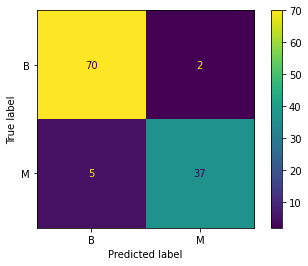

In [12]:
# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

_____

## Exercício 1

Para praticarmos e para comparar também, repita o mesmo procedimento com uma árvore de Decisão e com uma Floresta Aleatória. Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros para cada modelo - utilizando a estrutura do Pipeline conforme mostramos
- compare os resultados obtidos entre si e também com os resultados da regressão logística

_____

A classe `RandomizedSearchCV` apresenta vários atributos interessantes que podem ser manipulados, com maior detalhe no [LINK](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Dentre os principais podemos citar algumas:
- `param_distributions`: podemos aqui especificar uma distribuição estatística para gerar valores aleatórios ao invés de uma lista simples. Isso nos permite explorar situações e maiores espaços de busca de forma mais simples
- `n_iter`: aqui podemos controlar quantas amostras aleatórias serão realizadas. Temos de pensar no *trade-off* entre confiabilidade estatística vs custo computacional
- `n_jobs`: relativo à paralelização dos cálculos. Ajuda do aumento da velocidade da execução do algoritmo
- `refit`: se colocamos True, então ele vai ajustar um modelo final com os melhores parâmetros o que acelera nosso trabalho.

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy.stats import norm

In [14]:
# realizando a leitura dos dados
data = pd.read_csv('WineQT.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [15]:
# eliminando coluna Id
data.drop(['Id'], axis = 1, inplace = True)

In [16]:
# separando entre preditores e targets
x = data.drop(['quality'], axis = 1)
y = data[['quality']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', Lasso())]
pipe = Pipeline(steps)

In [18]:
# construindo o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# construindo um dicionário de DISTRIBUIÇÕES
param_dists = {
    'model__alpha': norm(loc = 1, scale = 0.5)
}

# objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dists, scoring='r2', cv=cvs, verbose = 10, n_iter=100, refit = True)
rs_cv.fit(x_train, y_train)

print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica:')
print(rs_cv.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 1/10; 1/100] END model__alpha=1.166683508872147;, score=-0.003 total time=   0.0s
[CV 2/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 2/10; 1/100] END model__alpha=1.166683508872147;, score=-0.003 total time=   0.0s
[CV 3/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 3/10; 1/100] END model__alpha=1.166683508872147;, score=-0.003 total time=   0.0s
[CV 4/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 4/10; 1/100] END model__alpha=1.166683508872147;, score=-0.003 total time=   0.0s
[CV 5/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 5/10; 1/100] END model__alpha=1.166683508872147;, score=-0.000 total time=   0.0s
[CV 6/10; 1/100] START model__alpha=1.166683508872147...........................
[CV 6/10; 1/100] EN

In [19]:
# analisando o melhor estimador
print(rs_cv.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.021488427026629675))])


In [21]:
# realizando novas estimativas
yhat = rs_cv.best_estimator_.predict(x_test)

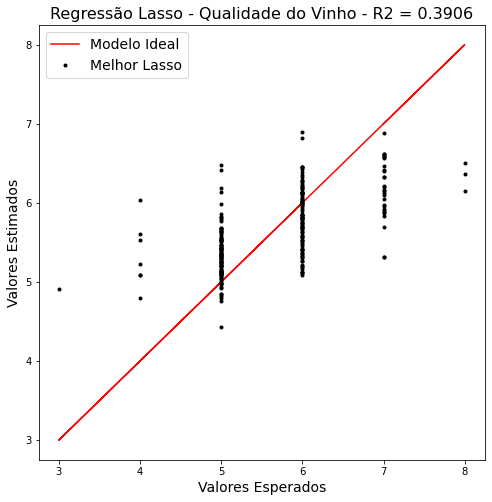

In [24]:
# gráfico com as predições
plt.figure(figsize=(8,8))
plt.plot(y_test, y_test, 'r-', label = 'Modelo Ideal')
plt.plot(y_test, yhat, 'k.', label = 'Melhor Lasso')
plt.xlabel('Valores Esperados', size=  14)
plt.ylabel('Valores Estimados', size = 14)
plt.title(f'Regressão Lasso - Qualidade do Vinho - R2 = {round(r2_score(y_test, yhat),4)}', size = 16)
plt.legend(loc = 'best', prop = {'size': 14})
plt.show()

_____

## Exercício 2

Para praticarmos e para comparar também, repita o mesmo procedimento com um KNN. Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros - utilizando a estrutura do Pipeline conforme mostramos
     - use uma distribuição uniforme para o valor de *k* entre 1 e 100
- compare os resultados obtidos entre si e também com os resultados da regressão linear

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy.stats import norm

In [4]:
# realizando a leitura dos dados
data = pd.read_csv('WineQT.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


_____

## Exercício 3

Para praticarmos e para comparar também, repita o mesmo procedimento com uma floresta aleatória Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros  - utilizando a estrutura do Pipeline conforme mostramos
   - use distribuições uniformes para o número de árvores e para a profundidade máxima
- aplique uma busca em Grade com muitos parâmetros para tentar encontrar o mesmo resultado.
- compare os resultados obtidos entre si